# Preparing Data for Figure 5

This notebook saves the processed data needed to plot **Figure 5** into a `.npz` file and then generates the corresponding plots.

**Important:**  
Before running this notebook, please make sure to execute the following notebooks in the `./save_results` directory. 
- [mouse_invariance_saveall.ipynb](https://github.com/MouseLand/minimodel/blob/main/figures/save_results/mouse_invariance_saveall.ipynb)
- [monkey_invariance_saveall.ipynb](https://github.com/MouseLand/minimodel/blob/main/figures/save_results/monkey_invariance_saveall.ipynb)

These notebooks:
- Load the raw neural and stimulus data,
- Run models for each animal (mouse and monkey),
- Save the model outputs needed for plotting.

Each notebook in `./save_results` corresponds to a specific condition or model variant. Skipping any of them may result in missing or incomplete data when running this notebook.


In [25]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from minimodel import data, model_builder, model_trainer, metrics

plt.rcParams.update({'font.size': 12})
device = torch.device('cuda')

data_dict = {}

data_path = '../notebooks/data'
weight_path = '../notebooks/checkpoints'
result_path = './save_results/outputs'

In [15]:
mouse_id = 5

# load images
if mouse_id == 5:
    xrange_max = 176
else:
    xrange_max = 130 
img = data.load_images(data_path, mouse_id, file=data.img_file_name[mouse_id])
nimg, Ly, Lx = img.shape
print('img: ', img.shape, img.min(), img.max(), img.dtype)

# load neurons
fname = '%s_nat60k_%s.npz'%(data.db[mouse_id]['mname'], data.db[mouse_id]['datexp'])
spks, istim_train, istim_test, xpos, ypos, spks_rep_all = data.load_neurons(file_path = os.path.join(data_path, fname), mouse_id = mouse_id, fixtrain=use_30k)
n_stim, n_max_neurons = spks.shape
print('spks: ', spks.shape, spks.min(), spks.max())
print('spks_rep_all: ', len(spks_rep_all), spks_rep_all[0].shape)
print('istim_train: ', istim_train.shape, istim_train.min(), istim_train.max())
print('istim_test: ', istim_test.shape, istim_test.min(), istim_test.max())

# split train and validation set
itrain, ival = data.split_train_val(istim_train, train_frac=0.9)
print('itrain: ', itrain.shape, itrain.min(), itrain.max())
print('ival: ', ival.shape, ival.min(), ival.max())

# normalize spks
spks, spks_rep_all = data.normalize_spks(spks, spks_rep_all, itrain)

img_val = torch.from_numpy(img[istim_train][ival]).to(device).unsqueeze(1)
img_test = torch.from_numpy(img[istim_test]).to(device).unsqueeze(1)
img_train = torch.from_numpy(img[istim_train][itrain]).to(device).unsqueeze(1) # change :130 to 25:100 

print('img_train: ', img_train.shape, img_train.min(), img_train.max())
print('img_val: ', img_val.shape, img_val.min(), img_val.max())
print('img_test: ', img_test.shape, img_test.min(), img_test.max())

input_Ly, input_Lx = img_train.shape[-2:]

ineur = np.arange(spks.shape[-1])
spks_train = torch.from_numpy(spks[itrain][:,ineur])
spks_val = torch.from_numpy(spks[ival][:,ineur]) 
spks_rep = [spks_rep_all[i][:,ineur] for i in range(len(spks_rep_all))]

raw image shape:  (68000, 66, 264)
cropped image shape:  (68000, 66, 130)
img:  (68000, 66, 130) -2.0829253 2.1060908 float32
img:  (68000, 66, 130) -2.0829253 2.1060908 float32

loading activities from ../notebooks/data/FX20_nat60k_2023_09_29.npz
spks:  (47868, 2746) -8.881784e-16 22.047676
spks_rep_all:  500 (10, 2746)
istim_train:  (47868,) 500 48867
istim_test:  (500,) 0 499

splitting training and validation set...
itrain:  (43081,)
ival:  (4787,)
itrain:  (43081,) 1 47867
ival:  (4787,) 0 47860

normalizing neural data...
finished
img_train:  torch.Size([43081, 1, 66, 130]) tensor(-2.0829, device='cuda:0') tensor(2.1061, device='cuda:0')
img_val:  torch.Size([4787, 1, 66, 130]) tensor(-2.0829, device='cuda:0') tensor(2.1061, device='cuda:0')
img_test:  torch.Size([500, 1, 66, 130]) tensor(-2.0829, device='cuda:0') tensor(2.1061, device='cuda:0')


In [16]:
# load minimodel catvar all
fpath = f'save_results/outputs/catvar_{data.db[mouse_id]["mname"]}_result.npz'
dat = np.load(fpath, allow_pickle=True)
catvar = dat['pred_catvar']
print(catvar.shape)      
valid_idxes = dat['valid_ineurons']
print(len(valid_idxes), np.max(valid_idxes))
isort_catvar = np.argsort(catvar)[::-1]

(768,)
768 2704


In [26]:
ineuron = 7 # 0-50, -50--1

# load minimodel
nlayers = 2
nconv1 = 16
nconv2 = 64
seed = 1

ineur = [valid_idxes[isort_catvar[ineuron]]]
spks_rep = [spks_rep_all[i][:,ineur] for i in range(len(spks_rep_all))]

# build model
wc_coef = 0.2
hs_readout = 0.03

model, in_channels = model_builder.build_model(NN=1, n_layers=nlayers, n_conv=nconv1, n_conv_mid=nconv2, Wc_coef=wc_coef)
model_name = model_builder.create_model_name(data.mouse_names[mouse_id], data.exp_date[mouse_id], ineuron=ineur[0], n_layers=nlayers, in_channels=in_channels, seed=seed,hs_readout=hs_readout)

model_path = os.path.join(weight_path, 'minimodel', model_name)
print('model path: ', model_path)
model.load_state_dict(torch.load(model_path))
print('loaded model', model_path)
model = model.to(device)

# test model
test_pred = model_trainer.test_epoch(model, img_test)
neuron_activity_model = model_trainer.test_epoch(model, img_train)
neuron_activity_model = neuron_activity_model.squeeze()

test_fev, test_feve = metrics.feve(spks_rep, test_pred)

icatvar = isort_catvar[ineuron]
print(f'neuron {ineuron}: catvar = ', catvar[icatvar])
print(f'neuron {ineuron}: FEVE = ', test_feve)
print(f'neuron {ineuron}: FEV = ', test_fev)

core shape:  torch.Size([1, 64, 33, 65])
input shape of readout:  (64, 33, 65)
model name:  FX20_092923_2layer_16_64_clamp_norm_depthsep_pool_nn1046_hs3e-02_xrange_176.pt
model path:  ../notebooks/checkpoints/minimodel/FX20_092923_2layer_16_64_clamp_norm_depthsep_pool_nn1046_hs3e-02_xrange_176.pt
loaded model ../notebooks/checkpoints/minimodel/FX20_092923_2layer_16_64_clamp_norm_depthsep_pool_nn1046_hs3e-02_xrange_176.pt
neuron 7: catvar =  0.11027572942249159
neuron 7: FEVE =  [0.7337246]
neuron 7: FEV =  [0.19966207]


In [28]:
# find the unique train images
Nimgs_unique = img_train.shape[0]
# get predictions of train images (in batches)
model.eval()
batch_size = 160
nconv2
wxy_fvs = np.zeros((Nimgs_unique, nconv2))
for i in range(0, Nimgs_unique, batch_size):
    images = img_train[i:i+batch_size].to(device)
    conv2_fv = model.core(images)
    wxy_fv = torch.einsum('iry, irx, ncyx -> ncr', model.readout.Wy, model.readout.Wx, conv2_fv).detach().cpu().numpy().squeeze()
    wxy_fvs[i:i+batch_size] = wxy_fv
print(wxy_fvs.shape, wxy_fvs.min(), wxy_fvs.max())

fv_isort = np.argsort(-wxy_fvs, axis=0)
wxy_fvs_sorted = np.sort(wxy_fvs, axis=0)[::-1]

Wc = model.readout.Wc.detach().cpu().numpy().squeeze()
# get valid channels
ivalid_Wc = np.where(np.abs(Wc)>0.01)[0]
print('ivalid_Wc:', len(ivalid_Wc))

fv_isort = fv_isort[:, ivalid_Wc]
wxy_fvs_sorted = wxy_fvs_sorted[:, ivalid_Wc]

fv_isort_top10 = fv_isort[:8]
wxy_fvs_sorted_top10 = wxy_fvs_sorted[:8]
Nimg, Nchannel = fv_isort_top10.shape
print(fv_isort_top10.shape)


from minimodel.utils import get_image_mask
ineuron_mask_up = get_image_mask(model, Ly=Ly, Lx=Lx)

prediction_isort = np.argsort(neuron_activity_model)[::-1]

(43081, 64) 0.0 7.282741546630859
ivalid_Wc: 22
(8, 22)
rf size: 352.00
cutted_mask_up:  (71, 125)
-27 98 -11 60 (71, 125)
adjusting xstart
adjusting ystart


(43081, 22)


Text(0, 0.5, 'Activity')

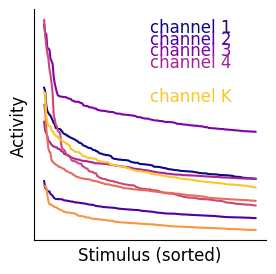

In [29]:
wxy_fvs_valid = wxy_fvs[:, ivalid_Wc]
print(wxy_fvs_valid.shape)
nchan = len(ivalid_Wc)
fig, ax = plt.subplots(1, 1, figsize=(3,3))
cmap = plt.get_cmap('plasma', 9)
for i in range(8):
    ic = i if i<6 else -(8-i)
    sorted_fv = np.sort(wxy_fvs_valid[:, ic])[::-1]
    ic = i+1 if i<6 else nchan+1-(8-i)
    ax.plot(sorted_fv[:200], color=cmap(i), label=f'channel {ic}')
    if i ==7:
        ax.text(0.5, 0.9-6*0.05, f'channel K', color=cmap(i), transform=ax.transAxes)
    elif i<4:
        ax.text(0.5, 0.9-i*0.05, f'channel {ic}', color=cmap(i), transform=ax.transAxes)
    # ax.set_axis_off()
    # plt.savefig(f'./outputs/{model_name}_channel_{ic}_activities.pdf', bbox_inches='tight', dpi=200)
# set right and top spine invisible
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Stimulus (sorted)')
ax.set_ylabel('Activity')


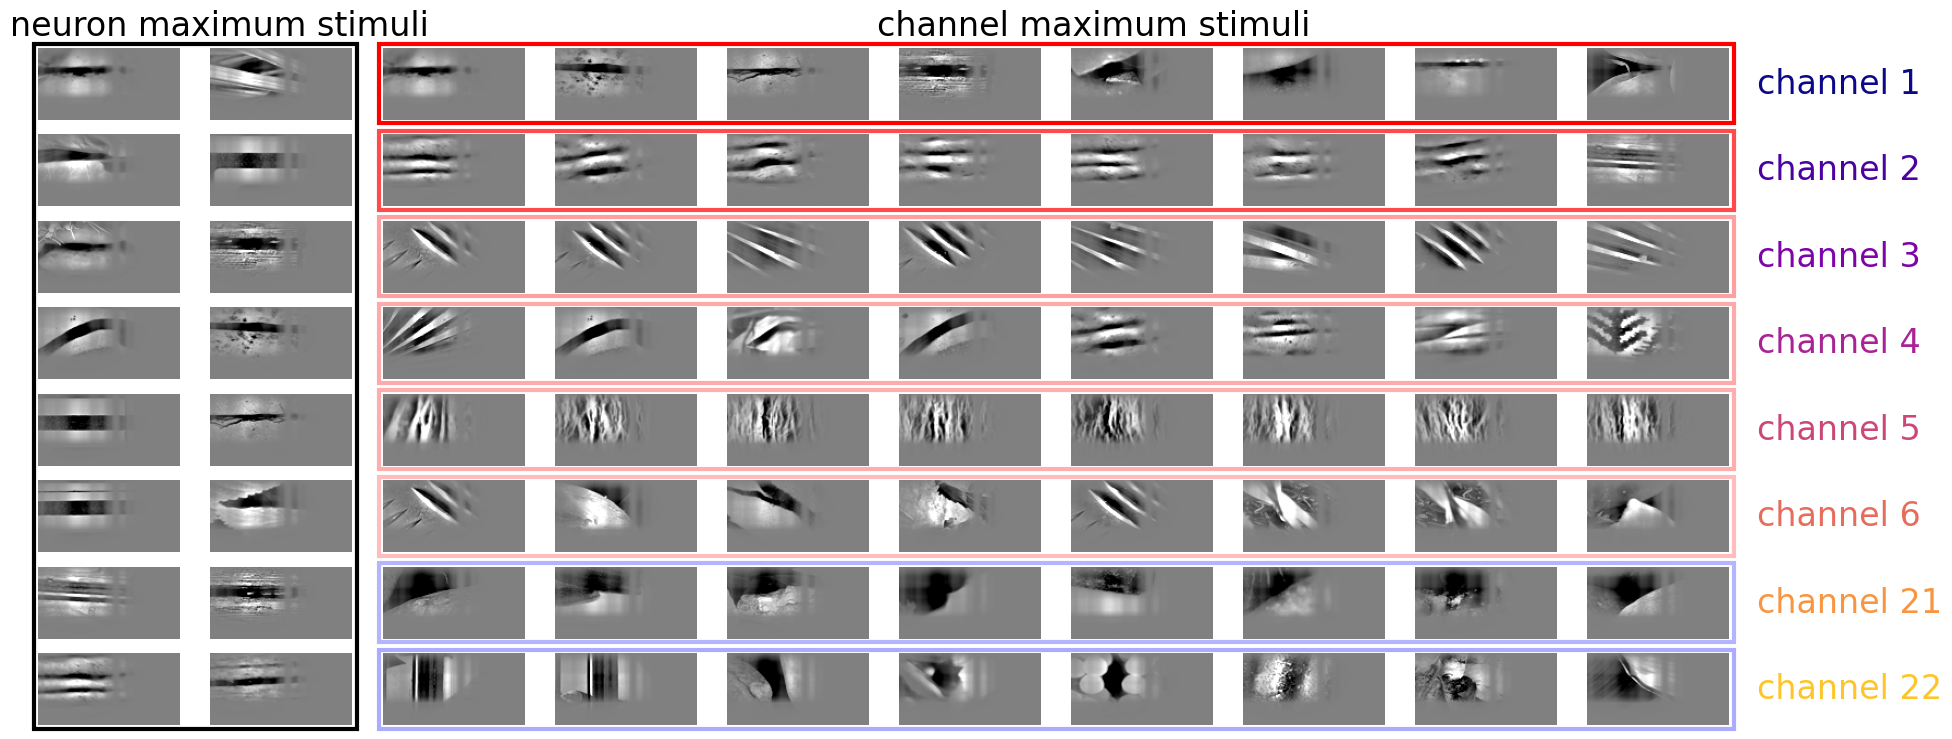

In [31]:
from matplotlib import patches
# Function to add a frame around a channel
def add_channel_frame(axs, row, col_start, col_end, color, alpha, monkey=False):
    ax = axs[row, col_start]  # Leftmost axis in the row
    if monkey: adjust_value = 1.1# 1.54# 1.64
    else: adjust_value = 1.193# 1.33
    # Rectangle coordinates (x, y) and dimensions (width, height)
    rect = patches.Rectangle(
        (-0.025, -0.05), (col_end - col_start + 1)*adjust_value , 1.1, transform=ax.transAxes,
        color=color, fill=False, linewidth=3, zorder=10, alpha=alpha,
        clip_on=False  # To ensure it draws outside the axes
    )
    ax.add_patch(rect)

cmap = plt.get_cmap('plasma', 9)
# Parameters for the second plot
pad = 5
vmin = 0
vmax = 255
valid_wc = Wc[ivalid_Wc]
isort = np.argsort(valid_wc)[::-1]
Nchannel = np.min([len(valid_wc), 8])

# Combined plot layout
fig = plt.figure(figsize=(Nimg + 14, 8 * 1.1))
gs = plt.GridSpec(8, Nimg + 2, figure=fig, hspace=0.2, wspace=0.1)#, width_ratios=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

# Plot one (4x4 grid on the left side, occupying 2 rows per row)
nshow = 16
for i in range(nshow):
    row = (i // 2) 
    col = (i % 2)
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(img_train[prediction_isort[i]].cpu().numpy().squeeze() * ineuron_mask_up, cmap='gray', vmin=-1, vmax=1)
    ax.axis('off')
    if i == 0:
        # add a rect around the 16 images
        rect = patches.Rectangle(
            (-0.03, -7.38-1.07), 2.275, 9.5, transform=ax.transAxes,
            color='black', fill=False, linewidth=3, zorder=10,
            clip_on=False  # To ensure it draws outside the axes
        )
        ax.add_patch(rect)
        ax.text(-0.2, 1.3, 'neuron maximum stimuli', transform=ax.transAxes,
                verticalalignment='center', fontsize=24, color='black')

# Plot two (8xNimg grid on the right side)
axs = np.empty((8, Nimg), dtype=object)
for i in range(Nchannel):
    if i < 6:
        ichannel = i
    else:
        ichannel = -(Nchannel - i)
    for j in range(Nimg):
        axs[i, j] = fig.add_subplot(gs[i, j + 2])
        # ax = axs[i, j + 4]  # Offset by 4 columns to place it on the right side
        axs[i, j].imshow(img_train[fv_isort_top10[j, isort[ichannel]]].cpu().numpy().squeeze() * ineuron_mask_up, cmap='gray', vmin=-1, vmax=1)
        axs[i, j].axis('off')
    wc_value = valid_wc[isort[ichannel]]
    # Determine the frame color and linewidth based on valid_wc[isort[ichannel]]
    if wc_value > 0:
        color = 'red'
    else:
        color = 'blue'
    # linewidth = np.abs(valid_wc[isort[ichannel]] / np.max(np.abs(valid_wc)))
    add_channel_frame(axs, i, 0, Nimg - 1, color, np.abs(valid_wc[isort[ichannel]]/np.max(np.abs(valid_wc))), monkey=False)

    ax = axs[i, Nimg - 1]  # Rightmost axis in the row
    if ichannel < 0: ichannel = len(valid_wc) + ichannel
    ax.text(1.2, 0.5, f'channel {ichannel+1}', transform=ax.transAxes,
            verticalalignment='center', fontsize=24, color=cmap(i))
    if i == 0:
        ax = axs[i, Nimg - 1]
        ax.text(-5, 1.3, 'channel maximum stimuli', transform=ax.transAxes,
                verticalalignment='center', fontsize=24, color='black') 
plt.show()

In [32]:
data_dict['wxy_fv'] = wxy_fvs_valid
data_dict['model_output'] = neuron_activity_model

# save

In [33]:
# save data_dict
np.savez(f'figure5_results.npz', **data_dict)

# plot

In [ ]:
import figure5
dat = np.load('figure5_results.npz', allow_pickle=True)
save_path = './outputs'
figure5.figure5(dat, save_path)